# <ins>CS-345 Coursework</ins>
### Rachel Newton-John - 2006652
This notebook creates and trains two machine learning models on the CIFAR100 dataset. The first is a state vector machine being trained on a set of features extracted from the image set. The second is a convolutional neural network.

<i>This notebook takes several hours the first time it is run. It saves intermediary values to disk to make subsequent runs shorter, but this means it also requires a significant amount of free disk space. It also uses a lot of memory, and will not work with less than 32GB of RAM</i>

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
from sklearn.linear_model import SGDClassifier
from os.path import exists
import gc
from sklearn.svm import SVC
import sklearn.decomposition as decomp
from IPython.display import display, HTML

In [2]:
# A function to display statistics about a trained neural networks performance. Saves some code repetition later in the notebook.
def displayHistory(results, history):
    print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')
    plt.figure(figsize=[10,5])
    plt.subplot(121)
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Training Accuracy',
               'Validation Accuracy'])
    plt.title('Accuracy Curves')

    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training Loss',
               'Validation Loss'])
    plt.title('Loss Curves')
    plt.show()

# Method 1 - Support Vector Machine
The first method of image classification that will be examined is training a support vector machine on an extracted set of features from the set of images that's been dimensionally reduced to improve efficiency. This will be done on both the fine classes and superclasses, and with varying degrees of dimensionality reduction on the output to assess it's impact on the end result.

## <ins>Preprocessing</ins>
#### <i>A Note On Code Structure...</i>
The loading and preprocessing of training and testing data is handled in separate sections in this notebook, with intermediary values being saved to and loaded from disk at various points. This is intentional, and it is done to reduce RAM usage so that the maximum amount of the dataset possible can be used to train the model but means that running the notebook requires a significant amount of available disk space. Principal component analysis is done on an incomplete subset of the training data for the same reason.

## Loading and extracting features from the data
Firstly, features must be extracted from the dataset. SKLearn's histogram of oriented gradients extractor is used for this, outputting for each image a flattened array of feature vectors that can be later used to train an SVM

In [22]:
trnLabelsCoarse = np.load("trnLabel_coarse.npy")
trnLabelsFine = np.load("trnLabel_fine.npy")
if (exists("trn_feature.npy")):
    trn_feature = np.load("trn_feature.npy")
else:
    trn_feature = np.ndarray(shape=(len(trnData),15876))
    trnData = np.load("trnImage.npy")
    trnData = np.moveaxis(trnData, (0,1,2,3), (1,2,3,0))
    for i in range(len(trnData)):
        trn_feature[i], hog_image = skimage.feature.hog(trnData[i], channel_axis=2, pixels_per_cell=[2,2], cells_per_block=[3,3], visualize=True)
    np.save("trn_feature", trn_feature)
    del(trnData)

### Performing dimensionality reduction using Principal Component Analysis
The extracted features data when flattened has 15876 values per image. This can, however, be transformed in such a way that the majority of these dimensions contribute little to no information to the final outcome. Setting a threshold after which to discard data will make the dataset easier to work with.

This is also a very slow process, so we save the results to avoid having to recompute them.

In [23]:
if (not exists("trn_transformed.npy") or not exists("tst_transformed.npy")):
    feature_PCA = decomp.PCA()
    feature_PCA.fit(trn_feature[:45000])
    np.save("variance", feature_PCA.explained_variance_ratio_)


In [24]:
if (not exists("trn_transformed.npy")):
    trn_transformed = feature_PCA.transform(trn_feature)
    np.save("trn_transformed", trn_transformed)
else:
    trn_transformed = np.load("trn_transformed.npy")


In [25]:
tstData = np.load("tstImage.npy")
tstData = np.moveaxis(tstData, (0,1,2,3), (1,2,3,0))
tstLabelsCoarse = np.load("tstLabel_coarse.npy")
tstLabelsFine = np.load("tstLabel_fine.npy")
if (exists("tst_feature.npy")):
    tst_feature = np.load("tst_feature.npy")
else:
    tst_feature = np.ndarray(shape=(len(tstData),15876))
    for i in range(len(tstData)):
        tst_feature[i,:], tst_image = skimage.feature.hog(tstData[i], channel_axis=2, pixels_per_cell=[2,2], cells_per_block=[3,3], visualize=True)
    np.save("tst_feature", tst_feature)

In [26]:
if (not exists("tst_transformed.npy")):
    tst_transformed = feature_PCA.transform(tst_feature)
    np.save("tst_transformed", tst_transformed)
else:
    tst_transformed = np.load("tst_transformed.npy")


### Reducing dimensions
This determines a set of dimensionalities which preserve different amounts of the original data's variance, to train a set of SVM's on. The purpose of this is to determine the impact of different degrees of dimensionality reduction on the accuracy of the SVM. The set of variance values to be used can be altered by modifying the code below.

In [27]:
VARIANCE_THRESHOLD = 0.62

variance = np.load("variance.npy")

dim_number = [1] * 10
for i in range(10):
    totVar = 0
    while (totVar <= VARIANCE_THRESHOLD):
        dim_number[i] += 1
        totVar = sum(variance[:dim_number[i]])
    VARIANCE_THRESHOLD += 0.04
    print(totVar, "of the variance can be preserved in", dim_number[i], "dimensions.")

0.62016076744644 of the variance can be preserved in 709 dimensions.
0.6602215546280262 of the variance can be preserved in 803 dimensions.
0.7003268688118857 of the variance can be preserved in 903 dimensions.
0.7401412621456527 of the variance can be preserved in 1009 dimensions.
0.7800035422953102 of the variance can be preserved in 1123 dimensions.
0.8200782642863965 of the variance can be preserved in 1248 dimensions.
0.860080780946862 of the variance can be preserved in 1389 dimensions.
0.9000946967310257 of the variance can be preserved in 1561 dimensions.
0.9400830296053774 of the variance can be preserved in 1839 dimensions.
0.9800063854619302 of the variance can be preserved in 2916 dimensions.


## Training the SVM
With the data transformed using PCA and the thresholds that we can use for varying degrees of dimensionality reduction established, we can now train the SVM on this data.
### Training on the superclasses
First, we will attempt to train 10 SVM's on the data with different variance thresholds, to determine the impact of discarding more and more data on the accuracy of the classifier. In theory, this is a tradeoff between accuracy and computational complexity.

In [34]:
SupportVecClass_coarse = [None] * 10
for i in range(10):
    print("Training with", dim_number[i], "dimensions.")
    SupportVecClass_coarse[i] = SGDClassifier(n_jobs=-1, loss='squared_hinge', max_iter=5000)
    SupportVecClass_coarse[i].fit(trn_transformed[:,:dim_number[i]], trnLabelsCoarse)
    print("Training took", SupportVecClass_coarse[i].n_iter_, "iterations.")

Training with 709 dimensions.
Training took 129 iterations.
Training with 803 dimensions.
Training took 132 iterations.
Training with 903 dimensions.
Training took 129 iterations.
Training with 1009 dimensions.
Training took 133 iterations.
Training with 1123 dimensions.
Training took 143 iterations.
Training with 1248 dimensions.
Training took 148 iterations.
Training with 1389 dimensions.
Training took 143 iterations.
Training with 1561 dimensions.
Training took 155 iterations.
Training with 1839 dimensions.
Training took 629 iterations.
Training with 2916 dimensions.
Training took 5000 iterations.


/home/rachel/src/venv/bdml/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


### Scoring the results
An SVM with enough dimensions to preserve 0.98 of the variance doesn't converge within the 5000 iteration limit set when the SVM's were created. This means it iterated on the dataset 5000 times, and then stopped, rather than stopping when the weights became stable and stopped changing.

In [35]:
for i in range(10):
    print(SupportVecClass_coarse[i].score(tst_transformed[:,:dim_number[i]], tstLabelsCoarse))

0.2176
0.213
0.2186
0.2165
0.2125
0.223
0.2174
0.2135
0.2319
0.1792


The results of this show that from 0.64 up to 0.90 of the original variance being preserved, discarding additional data doesn't have any significant impact on the accuracy of the classifier either way, with it staying at 21%. With 0.94 variance the accuracy increases to 23.2%, however. The final value, the accuracy for 0.98 variance, is the value that the SVM reached before it was terminated prematurely. If the iteration limit were higher, it would keep going and refine that value further.

### Creating a new coarse categorization SVM
To allow the above, very time consuming section to be skipped after it's been run once, the actual SVM we use to classify the data will be created and trained below.

In [28]:
SVC_coarse = SGDClassifier(n_jobs=-1, loss='squared_hinge', max_iter=5000)
SVC_coarse.fit(trn_transformed[:,:dim_number[8]], trnLabelsCoarse)


SGDClassifier(loss='squared_hinge', max_iter=5000, n_jobs=-1)

### Superclass Confusion Matrix

In [51]:
predict_SVC_coarse = SVC_coarse.predict(tst_transformed[:,:dim_number[8]])
confusion_matrix_coarse = np.zeros(shape=(20,20), dtype=np.int16)
for i in range(10000):
    confusion_matrix_coarse[tstLabelsCoarse[i], predict_SVC_coarse[i]] += 1
# This is some html trickery to prevent prints from wrapping, so that we can display more of the confusion matrix
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

for i in range(20):
    for j in range(20):
        print("|", confusion_matrix_coarse[i, j], end = "")
        if (confusion_matrix_coarse[i,j] < 10):
            print(" ", end="")
        if (confusion_matrix_coarse[i, j] < 100):
            print(" ", end="")
    print()
    print("+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----")


| 74 | 25 | 25 | 6  | 12 | 14 | 5  | 26 | 33 | 26 | 29 | 44 | 19 | 17 | 20 | 39 | 26 | 18 | 22 | 20 
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----
| 40 | 86 | 22 | 8  | 31 | 16 | 18 | 27 | 18 | 15 | 23 | 22 | 17 | 21 | 21 | 51 | 20 | 10 | 19 | 15 
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----
| 10 | 17 | 83 | 13 | 21 | 31 | 12 | 38 | 31 | 20 | 14 | 34 | 18 | 23 | 32 | 24 | 33 | 20 | 10 | 16 
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----
| 3  | 10 | 21 | 203| 19 | 48 | 34 | 12 | 17 | 13 | 6  | 15 | 5  | 13 | 23 | 7  | 12 | 3  | 18 | 18 
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----
| 16 | 19 | 38 | 42 | 99 | 24 | 11 | 21 | 30 | 16 | 11 | 21 | 21 | 20 | 28 | 20 | 19 | 11 | 23 | 10 
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+

The SVM trained on the superclasses has a sensitivity of 0.233 and a sinsitivity of 0.960. This is well below the benchmark accuract of 39.43%.

## Training on the fine categories
#### <i>If you value your time, skip the following two code cells!</i>
As with above, we will try to train a series of SVM's with different variances to assess it's impact on training accuracy...

In [ ]:
SupportVecClass_fine = [None] * 10
for i in range(10):
    print("Training with", dim_number[i], "dimensions.")
    SupportVecClass_fine[i] = SGDClassifier(n_jobs=-1, loss='squared_hinge', max_iter=5000)
    SupportVecClass_fine[i].fit(trn_transformed[:,:dim_number[i]], trnLabelsFine)
    print("Training took", SupportVecClass_fine[i].n_iter_, "iterations.")

Training with 709 dimensions.


/home/rachel/src/venv/bdml/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Training took 5000 iterations.
Training with 803 dimensions.


/home/rachel/src/venv/bdml/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Training took 5000 iterations.
Training with 903 dimensions.


/home/rachel/src/venv/bdml/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Training took 5000 iterations.
Training with 1009 dimensions.


...however, being trained on the finer categories, it is failing to converge at any dimensionality. Furthermore, each individual attempt at training it can take over an hour before it finally does terminate.

In [ ]:
for i in range(10):
    print(SupportVecClass_fine[i].score(tst_transformed[:,:dim_number[i]], tstLabelsFine))

### Creating a new fine categorization SVM
Because it is <i>strongly encouraged</i> to skip the above section, a single SVM to use with the fine categories will be created and trained below.
<i>This can still take an extremely long time to train. To reduce the training time, reduce the number of dimensions being used with it by reducing the index of the dim_number array.</i> By default we are using 0.94 of the original variance.

In [15]:
SVC_fine = SGDClassifier(n_jobs=-1, loss='squared_hinge', max_iter=5000)
SVC_fine.fit(trn_transformed[:,:dim_number[8]], trnLabelsFine)

/home/rachel/src/venv/bdml/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:704: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDClassifier(loss='squared_hinge', max_iter=5000, n_jobs=-1)

### Fine Class Confusion Matrix
This shows both a part of the full confusion matrix for the entire testing dataset, and a set of one vs all matrices for individual classes. <i>To view the confusion matrix properly, your browser window must be wide enough that the print statements do not wrap</i>

In [61]:
predict_SVC_fine = SVC_fine.predict(tst_transformed[:,:dim_number[8]])
confusion_matrix_fine = np.zeros(shape=(100,2,2), dtype=np.int16)
for i in range(10000):
    for j in range(100):
        confusion_matrix_fine[j,0 if tstLabelsFine[i] == j else 1, 0 if predict_SVC_fine[i] == j else 1] += 1
avg_matrix_fine = np.zeros(shape=(2,2))
for i in range(10):
    print(confusion_matrix_fine[i])
    print()
for i in range(100):
    avg_matrix_fine += confusion_matrix_fine[i]
avg_matrix_fine /= 100
print(avg_matrix_fine)

[[  35   65]
 [  69 9831]]

[[  12   88]
 [  99 9801]]

[[   1   99]
 [  98 9802]]

[[   1   99]
 [  51 9849]]

[[   1   99]
 [  57 9843]]

[[  11   89]
 [  74 9826]]

[[   6   94]
 [  88 9812]]

[[   1   99]
 [  88 9812]]

[[  28   72]
 [  63 9837]]

[[  38   62]
 [  59 9841]]

[[  11.9   88.1]
 [  88.1 9811.9]]


In [56]:
predict_SVC_fine = SVC_fine.predict(tst_transformed[:,:dim_number[8]])
confusion_matrix_fine = np.zeros(shape=(100,100), dtype=np.int16)
for i in range(10000):
    confusion_matrix_fine[tstLabelsFine[i], predict_SVC_fine[i]] += 1
# This is some HTML trickery to prevent prints from wrapping, so that we can display more of the confusion matrix
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

for i in range(30):
    for j in range(30):
        print("|", confusion_matrix_fine[i, j], end = "")
        if (confusion_matrix_fine[i,j] < 10):
            print(" ", end="")
        if (confusion_matrix_fine[i, j] < 100):
            print(" ", end="")
    print()
    print("+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----")


| 35 | 0  | 1  | 2  | 2  | 0  | 0  | 0  | 0  | 1  | 2  | 1  | 1  | 0  | 0  | 0  | 0  | 0  | 0  | 1  | 0  | 0  | 0  | 0  | 1  | 0  | 1  | 0  | 0  | 0  
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----
| 0  | 12 | 0  | 0  | 0  | 1  | 1  | 1  | 0  | 1  | 0  | 1  | 0  | 1  | 0  | 2  | 0  | 0  | 0  | 0  | 0  | 3  | 0  | 1  | 2  | 1  | 2  | 2  | 0  | 3  
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----
| 1  | 0  | 1  | 0  | 3  | 1  | 0  | 1  | 0  | 2  | 0  | 2  | 0  | 0  | 2  | 0  | 0  | 0  | 1  | 1  | 0  | 0  | 0  | 0  | 0  | 0  | 1  | 0  | 1  | 0  
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----
| 0  | 0  | 1  | 1  | 0  | 0  | 1  | 0  | 2  | 1  | 0  | 1  | 1  | 1  | 0  | 0  | 0  | 1  | 0 

The SVM trained on the fine classes has a sensitivity of 0.119 and a specificity of 0.991. Though about 10x better than random chance, this is also well below the benchmark accuracy of 24.49%. This, combined with the low sensitivity of the coarse label SVM, suggests that these methods or this implementation of these methods is not suitable for this task.

# <ins>Method 2 - Convolutional Neural Network</ins>
The second method of image classification we will be experimenting with is training a convolutional neural network on the dataset. Unlike with the SVM, the dataset will not have any feature extraction or dimensionality reduction applied before the network is trained on it.

### Loading the data
First the training and testing datasets have to be laoded, and the axis rearranged to fit the format that the neural network input is expecting (The data is width,height,channels,samples but the network expects samples,width,height,channels).

In [3]:
trnData = np.load("trnImage.npy")
trnData = np.moveaxis(trnData, (0,1,2,3), (1,2,3,0))
trnLabelsCoarse = np.load("trnLabel_coarse.npy")
trnLabelsFine = np.load("trnLabel_fine.npy")
tstData = np.load("tstImage.npy")
tstData = np.moveaxis(tstData, (0,1,2,3), (1,2,3,0))
tstLabelsCoarse = np.load("tstLabel_coarse.npy")
tstLabelsFine = np.load("tstLabel_fine.npy")

## A model for the coarse labels
### Creating the model
Next we have to create the model to be trained. The model we are using has three 2D convolutional layers, and two dense neuron layers to classify the output. It uses pooling and dropout layers after each convolutional layer to reduce overfitting and make the feature extraction more orientation invariant, and has a regularization function on the second convolution layer.

In [4]:
model_coarse = tf.keras.models.Sequential()
model_coarse.add(tf.keras.layers.Conv2D(400, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_coarse.add(tf.keras.layers.Dropout(0.1))
model_coarse.add(tf.keras.layers.MaxPooling2D((3, 3)))
model_coarse.add(tf.keras.layers.Conv2D(200, (2, 2), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.0014)))
model_coarse.add(tf.keras.layers.Dropout(0.3))
model_coarse.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_coarse.add(tf.keras.layers.Conv2D(100, (2, 2), activation='sigmoid'))
model_coarse.add(tf.keras.layers.Dropout(0.2))
model_coarse.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_coarse.add(tf.keras.layers.Flatten())
model_coarse.add(tf.keras.layers.Dense(200))
model_coarse.add(tf.keras.layers.Dense(100))
model_coarse.summary()
model_coarse.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

2022-12-19 07:03:20.788080: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 07:03:21.348550: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 07:03:21.348611: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 07:03:21.349560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other oper

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 400)       11200     
                                                                 
 dropout (Dropout)           (None, 30, 30, 400)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 400)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 200)         320200    
                                                                 
 dropout_1 (Dropout)         (None, 9, 9, 200)         0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 200)        0         
 2D)                                                    

2022-12-19 07:03:21.917787: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:21.919612: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:21.926838: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:21.927409: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:21.934234: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:21.939049: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:21.941515: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:21.944063: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:21.945695: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:21

### Training the model
Now that the model has been created, we just have to train it. We're training it for 100 epochs by default. This can be changed, but too short risks the model not being as accurate as it could be while too long increases the risk of overfitting.

After training the model is evaluated against the test dataset. The results of these are stored in the variables history_coarse and results_coarse, which we will use later to assess the effectiveness of the network.

In [5]:
history_coarse = model_coarse.fit(trnData, trnLabelsCoarse, epochs=100, validation_split=0.2, verbose=0)
results_coarse = model_coarse.evaluate(tstData, tstLabelsCoarse)

2022-12-19 07:03:29.791051: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:29.792565: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:29.798198: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:29.798942: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:29.803470: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:29.804485: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:29.918943: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:29.920020: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:29.925145: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:03:29

 52/313 [===>..........................] - ETA: 0s - loss: 1.7262 - sparse_categorical_accuracy: 0.4886

2022-12-19 07:15:29.503368: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:15:29.510255: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:15:29.549804: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:15:29.555334: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:15:29.560236: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:15:29.563935: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


313/313 [==============================] - 1s 2ms/step - loss: 1.7306 - sparse_categorical_accuracy: 0.4870


## A model for the fine labels
Everything above, creating the model and training it, was to classify the dataset into the coarse categories. We also want to classify the data into the fine categories, so we'll do all of the above again, but this time train the network on the fine labels rather than the coarse ones.

Unlike the SVM, this shouldn't scale with the increased number of labels it's being trained against. However long the first network took to train, this one should take roughly the same time.

In [9]:
model_fine = tf.keras.models.Sequential()
model_fine.add(tf.keras.layers.Conv2D(400, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_fine.add(tf.keras.layers.Dropout(0.1))
model_fine.add(tf.keras.layers.MaxPooling2D((3, 3)))
model_fine.add(tf.keras.layers.Conv2D(200, (2, 2), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.0014)))
model_fine.add(tf.keras.layers.Dropout(0.3))
model_fine.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_fine.add(tf.keras.layers.Conv2D(100, (2, 2), activation='sigmoid'))
model_fine.add(tf.keras.layers.Dropout(0.2))
model_fine.add(tf.keras.layers.MaxPooling2D((2, 2)))
model_fine.add(tf.keras.layers.Flatten())
model_fine.add(tf.keras.layers.Dense(200))
model_fine.add(tf.keras.layers.Dense(100))
model_fine.summary()
model_fine.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 400)       11200     
                                                                 
 dropout_3 (Dropout)         (None, 30, 30, 400)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 10, 400)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 9, 9, 200)         320200    
                                                                 
 dropout_4 (Dropout)         (None, 9, 9, 200)         0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 200)        0         
 2D)                                                  

In [10]:
history_fine = model_fine.fit(trnData, trnLabelsFine, epochs=100, validation_split=0.2, verbose=0)
results_fine = model_fine.evaluate(tstData, tstLabelsFine)

2022-12-19 07:31:42.154525: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:31:42.159427: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:31:42.273764: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:31:42.280505: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:31:42.284316: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:31:42.287646: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:31:43.001816: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:31:49.820648: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:31:49.826858: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:31:49

 51/313 [===>..........................] - ETA: 0s - loss: 2.6044 - sparse_categorical_accuracy: 0.3560

2022-12-19 07:43:39.793638: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:43:39.800621: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:43:39.834673: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:43:39.840377: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:43:39.845347: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:43:39.849093: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


313/313 [==============================] - 1s 2ms/step - loss: 2.5884 - sparse_categorical_accuracy: 0.3556


## Model results
Now that the CNNs have been trained on the coarse and fine labels, we can examine the results. Below are accuracy and loss curves for the model on each set of labels, along with one-vs-all matrices for individual classes, the confusion matrix for the superclasses, and a region of the confusion matrix for the finer classes.
### Superclasses

Test set loss: 1.73, test set accuracy: 48.70%


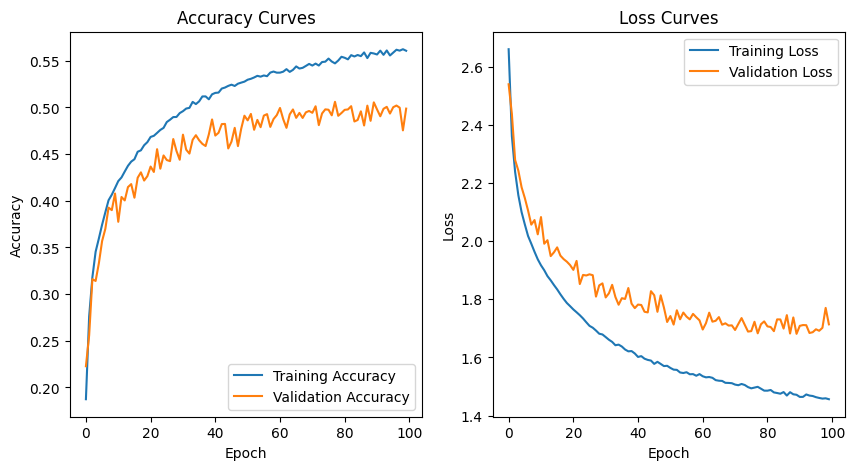

In [6]:
displayHistory(results_coarse, history_coarse)

This training history shows that the model is overfitting the data slightly. Ideally, the training and validation accuracy should be as close together as possible. However, the validation accuracy is ultimately the measure of how accurate the classifier is and 48.7% is pretty good.

In [13]:
proba_cnn_coarse = model_coarse.predict(tstData)
predict_cnn_coarse = np.argmax(proba_cnn_coarse, axis=1)
confusion_matrix_coarse = np.zeros(shape=(20,2,2), dtype=np.int16)
for i in range(10000):
    for j in range(20):
        confusion_matrix_coarse[j,0 if tstLabelsCoarse[i] == j else 1, 0 if predict_cnn_coarse[i] == j else 1] += 1
avg_matrix_coarse = np.zeros(shape=(2,2))
for i in range(20):
    print(confusion_matrix_coarse[i])
    print()
for i in range(20):
    avg_matrix_coarse += confusion_matrix_coarse[i]
avg_matrix_coarse /= 20
print(avg_matrix_coarse)

 81/313 [======>.......................] - ETA: 0s

2022-12-19 07:49:23.796803: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:49:23.803665: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:49:23.836286: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:49:23.842083: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:49:23.846963: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 07:49:23.849898: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


313/313 [==============================] - 0s 1ms/step
[[ 275  225]
 [ 623 8877]]

[[ 224  276]
 [ 285 9215]]

[[ 362  138]
 [ 148 9352]]

[[ 234  266]
 [ 203 9297]]

[[ 282  218]
 [ 123 9377]]

[[ 196  304]
 [ 241 9259]]

[[ 288  212]
 [ 221 9279]]

[[ 218  282]
 [ 178 9322]]

[[ 252  248]
 [ 462 9038]]

[[ 276  224]
 [ 226 9274]]

[[ 352  148]
 [ 220 9280]]

[[ 101  399]
 [  74 9426]]

[[ 148  352]
 [ 132 9368]]

[[ 259  241]
 [ 719 8781]]

[[ 219  281]
 [  26 9474]]

[[ 148  352]
 [ 332 9168]]

[[ 202  298]
 [ 394 9106]]

[[ 430   70]
 [ 243 9257]]

[[ 192  308]
 [ 103 9397]]

[[ 212  288]
 [ 177 9323]]

[[ 243.5  256.5]
 [ 256.5 9243.5]]


In [8]:
confusion_matrix_coarse = np.zeros(shape=(20,20), dtype=np.int16)
for i in range(10000):
    confusion_matrix_coarse[tstLabelsCoarse[i], predict_cnn_coarse[i]] += 1
# This is some html trickery to prevent prints from wrapping, so that we can display more of the confusion matrix
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

for i in range(20):
    for j in range(20):
        print("|", confusion_matrix_coarse[i, j], end = "")
        if (confusion_matrix_coarse[i,j] < 10):
            print(" ", end="")
        if (confusion_matrix_coarse[i, j] < 100):
            print(" ", end="")
    print()
    print("+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----")


| 275| 42 | 0  | 1  | 0  | 9  | 0  | 4  | 29 | 6  | 14 | 5  | 11 | 29 | 2  | 22 | 38 | 7  | 0  | 6  
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----
| 74 | 224| 13 | 4  | 10 | 9  | 6  | 4  | 3  | 12 | 20 | 8  | 4  | 33 | 2  | 32 | 25 | 9  | 4  | 4  
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----
| 1  | 13 | 362| 11 | 33 | 2  | 3  | 14 | 6  | 0  | 5  | 2  | 2  | 21 | 0  | 9  | 6  | 7  | 1  | 2  
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----
| 10 | 16 | 8  | 234| 12 | 57 | 30 | 11 | 10 | 15 | 7  | 0  | 3  | 45 | 3  | 10 | 14 | 6  | 0  | 9  
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----
| 8  | 12 | 46 | 17 | 282| 7  | 3  | 13 | 21 | 3  | 5  | 5  | 2  | 35 | 4  | 12 | 12 | 11 | 2  | 0  
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+

Trained on the coarse superclasses, the CNN has a sensitivity of 0.474 and specificity of 0.972. An interesting thing on the 14th collumn of the confusion matrix, it looks like the CNN is identifying a lot of things as belonging to that category, that's a lot of false positives. Why could that be?

### Fine classes

Test set loss: 2.59, test set accuracy: 35.56%


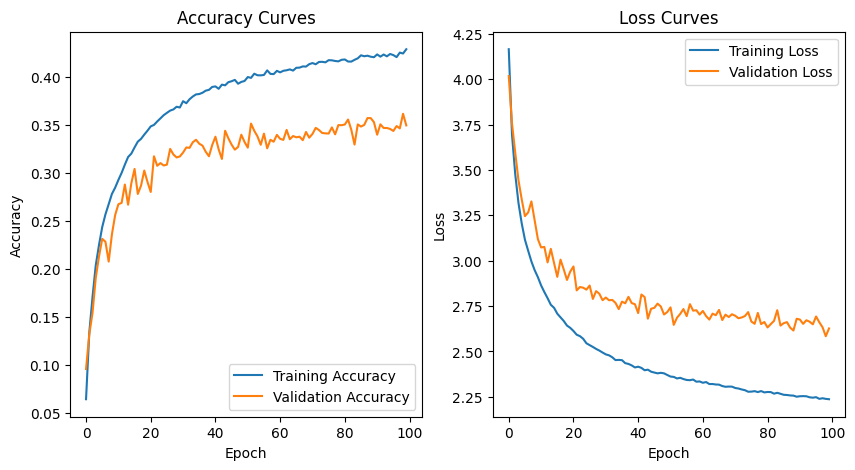

In [11]:
displayHistory(results_fine, history_fine)

As above, the data is overfit slightly. It also looks like the validation accuracy was on an upwards trend when it was terminated - this could be made more accurate by running it for longer.

In [19]:
proba_cnn_fine = model_fine.predict(tstData)
predict_cnn_fine = np.argmax(proba_cnn_fine, axis=1)
confusion_matrix_fine = np.zeros(shape=(100,2,2), dtype=np.int16)
for i in range(10000):
    for j in range(100):
        confusion_matrix_fine[j,0 if tstLabelsFine[i] == j else 1, 0 if predict_cnn_fine[i] == j else 1] += 1
avg_matrix_fine = np.zeros(shape=(2,2), dtype=float)
for i in range(20):
    print(confusion_matrix_fine[i])
    print()
for i in range(100):
    avg_matrix_fine += confusion_matrix_fine[i]
avg_matrix_fine /= 100
print(avg_matrix_fine)

 81/313 [======>.......................] - ETA: 0s

2022-12-19 08:07:44.333285: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 08:07:44.340085: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 08:07:44.372760: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 08:07:44.378467: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 08:07:44.383444: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2022-12-19 08:07:44.386440: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


313/313 [==============================] - 0s 1ms/step
[[  72   28]
 [  24 9876]]

[[  47   53]
 [  65 9835]]

[[  26   74]
 [  55 9845]]

[[  14   86]
 [  79 9821]]

[[  17   83]
 [  80 9820]]

[[  14   86]
 [  42 9858]]

[[  40   60]
 [  45 9855]]

[[  33   67]
 [  33 9867]]

[[  54   46]
 [  93 9807]]

[[  56   44]
 [ 121 9779]]

[[  21   79]
 [ 104 9796]]

[[  13   87]
 [  20 9880]]

[[  39   61]
 [  51 9849]]

[[  14   86]
 [  14 9886]]

[[  18   82]
 [  27 9873]]

[[  25   75]
 [  26 9874]]

[[  28   72]
 [  40 9860]]

[[  55   45]
 [  31 9869]]

[[  27   73]
 [  79 9821]]

[[  20   80]
 [  34 9866]]

[[  35.56   64.44]
 [  64.44 9835.56]]


In [16]:
confusion_matrix_fine = np.zeros(shape=(100,100), dtype=np.int16)
for i in range(10000):
    confusion_matrix_fine[tstLabelsFine[i], predict_cnn_fine[i]] += 1
# This is some html trickery to prevent prints from wrapping, so that we can display more of the confusion matrix
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

for i in range(50):
    for j in range(30):
        print("|", confusion_matrix_fine[i, j], end = "")
        if (confusion_matrix_fine[i,j] < 10):
            print(" ", end="")
        if (confusion_matrix_fine[i, j] < 100):
            print(" ", end="")
    print()
    print("+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----")


| 72 | 2  | 0  | 0  | 0  | 0  | 0  | 1  | 0  | 0  | 3  | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 1  | 0  | 1  | 0  | 0  | 0  | 0  
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----
| 1  | 47 | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 1  | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 1  | 0  | 0  | 0  | 0  | 0  | 1  | 1  | 0  | 0  | 0  
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----
| 0  | 2  | 26 | 0  | 1  | 3  | 0  | 0  | 0  | 1  | 3  | 1  | 0  | 0  | 0  | 1  | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 1  | 0  | 2  | 1  | 1  | 1  | 0  
+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----
| 0  | 0  | 0  | 14 | 3  | 0  | 0  | 1  | 0  | 2  | 0  | 0  | 0  | 0  | 0  | 1  | 0  | 0  | 0 

On the fine labels, it doesn't have the same issue it did with the coarse labels where one category got a disproportionate amount of false positives. Other than the sparse hotspots where one specific category is frequently mistaken for another specific category, this is far more even than the coarse labels.